# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Functions for my simulations
from dyn_cond_fig_functions import *


# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [6]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    # "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
    "axes.grid": True,
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Figure 4a

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

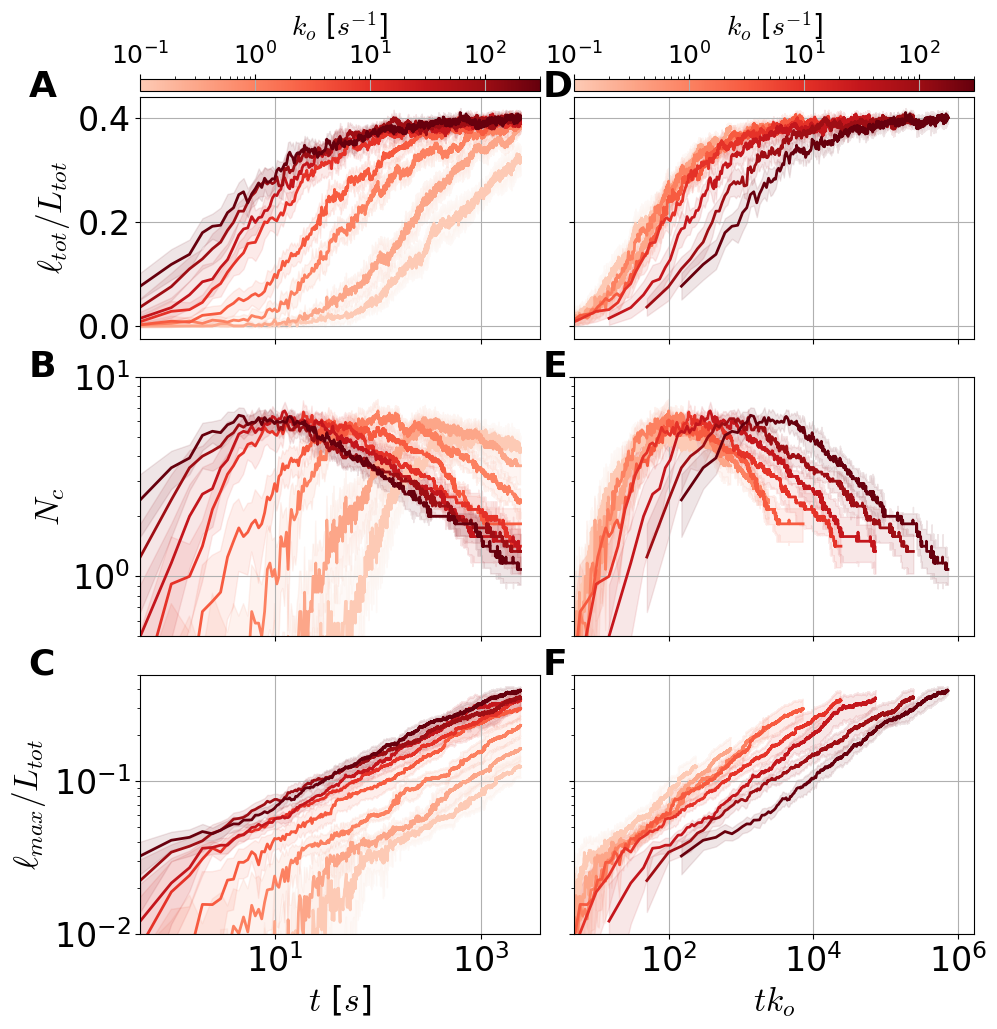

In [9]:
labels_to_graph_dict = {
                  r'$k_o = 0.1~s^{-1}$' : "kod0.1_Pin7.0um/",
                  r'$k_o = 0.3~s^{-1}$' : "kod0.3_Pin7.0um/",
                  r'$k_o = 1~s^{-1}$' : "kod1_Pin7.0um/",
                  r'$k_o = 3~s^{-1}$' : "kod3_Pin7.0um/",
                  r'$k_o = 10~s^{-1}$' : "kod10_Pin7.0um/",
                  r'$k_o = 30~s^{-1}$' : "kod30_Pin7.0um/",
                  r'$k_o = 100~s^{-1}$' : "kod100_Pin7.0um/",
                  r'$k_o = 300~s^{-1}$' : "kod300_Pin7.0um/",
                  }

cmap = plt.cm.Reds
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

fig, axarr = plt.subplots(3, 2, figsize=(10, 10), sharex='col', sharey='row')
with h5py.File('Figure4/fig4_pin_ko_data_dict.h5', 'r') as h5d:
    time_arr = h5d['time'][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        kod = float(re.search(r'kod(\d+\.?\d*)', key).group(1))

        num_runs = h5_data.attrs['num_runs']

        # beads in condenates
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(axarr[0,0], time_arr[1:min_length], mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)
        plot_confidence_int(axarr[0,1], time_arr[1:min_length]*kod, mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label)

        # Number of condensates
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        plot_confidence_int(
            axarr[1,0], time_arr[1:min_length], mean[1:], std_dev[1:], num_runs, color=color, label=label
        )
        plot_confidence_int(
            axarr[1,1], time_arr[1:min_length]*kod, mean[1:], std_dev[1:], num_runs, color=color, label=label
        )


        # Beads in largest condensate
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        plot_confidence_int(
            axarr[2,0], time_arr[1:min_length], mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label
        )
        plot_confidence_int(
            axarr[2,1], time_arr[1:min_length]*kod, mean[1:]/1600, std_dev[1:]/1600, num_runs, color=color, label=label
        )


    _ = axarr[0,0].set_ylabel("$\ell_{tot} / L_{tot}$")
    _ = axarr[0,0].set_xscale('log')
    _ = axarr[0,1].set_xscale('log')

    _ = axarr[1,0].set_ylabel("$N_c$")

    _ = axarr[2,0].set_ylabel(
        r"$\ell_{max} / L_{tot}$"
    )

    # _ = axarr[0,1].legend(loc='center right', bbox_to_anchor=(1, .4))
    # _ = axarr[0,1].legend(loc='upper left')

    _ = axarr[2,0].set_xlabel('$t$ [$s$]')
    _ = axarr[2,1].set_xlabel(r'$tk_o$')
    fig.tight_layout()

_ = axarr[0,0].set_xlim(0.5)

_ = axarr[1,0].set_ylim(0.5, 10.)
_ = axarr[1,0].set_yscale('log')

_ = axarr[2,0].set_ylim(0.01, 0.5)
_ = axarr[2,0].set_yscale('log')

# _ = axarr[1,0].plot(np.arange(30, 4000), 12*np.power(np.arange(30, 4000), -1./3.), 'k--', label=r'$1/N$')
# _ = axarr[2,0].plot(np.arange(5, 4000), .05*np.power(np.arange(5, 4000), 1./3.), 'k--', label=r'$1/N$')
# _ = axarr[2,1].plot(np.arange(1000, 1000000, 10000), .004*np.power(np.arange(1000, 1000000, 10000), 1./3.), 'k--', label=r'$1/N$')

_ = axarr[2,1].set_xlim(5)


norm = mcolors.LogNorm(vmin=.1, vmax=300)
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

cax0 = make_axes_locatable(axarr[0,0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04)

cax1 = make_axes_locatable(axarr[0,1]).append_axes("top", size="5%", pad=0.06)
cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04)

cbar.ax.tick_params(labelsize=18)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$k_o$ [$s^{-1}$]', fontsize=20)

cbar1.ax.tick_params(labelsize=18)
cbar1.ax.xaxis.set_ticks_position('top')
cbar1.ax.xaxis.set_label_position('top')
cbar1.set_label('$k_o$ [$s^{-1}$]', fontsize=20)

# _ = axarr[1,0].text(200, 1.1, "$\sim t^{-1/3}$", fontsize=20, fontweight='bold', va='top')
# _ = axarr[2,0].text(10, .3, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')
# _ = axarr[2,1].text(10000, .1, "$\sim t^{1/3}$", fontsize=20, fontweight='bold', va='top')


_ = axarr[0,0].text(-0.28, 1.00, "A", fontsize=26, transform=axarr[0,0].transAxes, fontweight='bold')
_ = axarr[1,0].text(-0.28, 1.00, "B", fontsize=26, transform=axarr[1,0].transAxes, fontweight='bold')
_ = axarr[2,0].text(-0.28, 1.00, "C", fontsize=26, transform=axarr[2,0].transAxes, fontweight='bold')
_ = axarr[0,1].text(-0.08, 1.0, "D", fontsize=26, transform=axarr[0,1].transAxes, fontweight='bold')
_ = axarr[1,1].text(-0.08, 1.0, "E", fontsize=26, transform=axarr[1,1].transAxes, fontweight='bold')
_ = axarr[2,1].text(-0.08, 1.0, "F", fontsize=26, transform=axarr[2,1].transAxes, fontweight='bold')

fig.savefig('Figure4/fig4_pin_ko.png', dpi=600, bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig4_cond_dyn_ko.png", dpi=300, bbox_inches="tight")

# Supplementary Figures

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


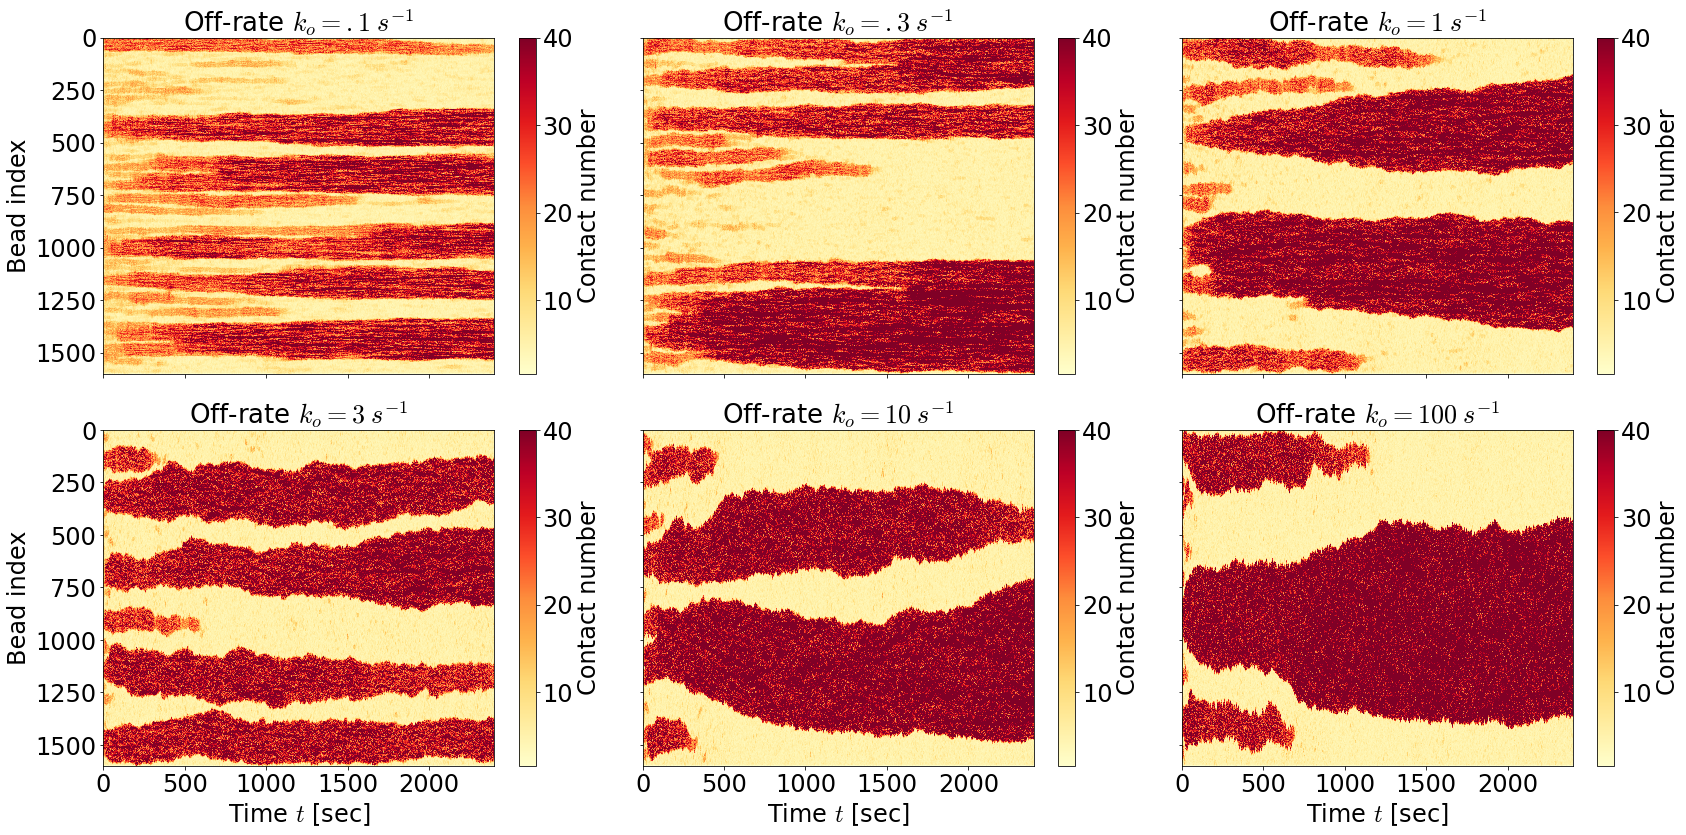

In [3]:
data_path = ceph_path / "DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100//"
fig, axarr = plt.subplots(2,3, figsize=(24, 12), sharex=True, sharey=True)

title_params = {'fontsize': 26}

kymo_contact_graph(fig, axarr[0,0], 
                   data_path / 'simulations/kod0.1_Pin5.0um/s1')
_ = axarr[0,0].set_title("Off-rate $k_o = .1\;s^{-1}$", **title_params)

# kymo_contact_graph(fig, axarr[1,0],
#                    data_path / 'simulations/kod0.3_Pin5.0um')
# _ = axarr[1,0].set_title("Off-rate $k_o = .3\;s^{-1}$")

kymo_contact_graph(fig, axarr[0,1],
                   data_path / 'simulations/kod0.3_Pin5.0um/s1')
_ = axarr[0,1].set_title("Off-rate $k_o = .3\;s^{-1}$", **title_params)

kymo_contact_graph(fig, axarr[0,2],
                   data_path / 'simulations/kod1_Pin5.0um/s1')
_ = axarr[0,2].set_title("Off-rate $k_o = 1\;s^{-1}$", **title_params)

# _ = axarr[2,0].set_title("End-to-end distance = 5.0 $\mu$m")
# kymo_contact_graph(fig, axarr[0,1],
#                    data_path / 'simulations/kod30_Pin5.0um')
# _ = axarr[0,1].set_title("End-to-end distance = 7.0 $\mu$m")

kymo_contact_graph(fig, axarr[1,0],
                   data_path / 'simulations/kod3_Pin5.0um/s1')
_ = axarr[1,0].set_title("Off-rate $k_o = 3\;s^{-1}$", **title_params)

kymo_contact_graph(fig, axarr[1,1],
                   data_path / 'simulations/kod10_Pin5.0um/s1')
_ = axarr[1,1].set_title("Off-rate $k_o = 10\;s^{-1}$", **title_params)

kymo_contact_graph(fig, axarr[1,2],
                   data_path / 'simulations/kod100_Pin5.0um/s1')
_ = axarr[1,2].set_title("Off-rate $k_o = 100\;s^{-1}$", **title_params)

# kymo_contact_graph(fig, axarr[2,1],
#                    data_path / 'simulations/kod300_Pin5.0um')
# _ = axarr[2,1].set_title("End-to-end distance = 11.0 $\mu$m")

for ax in axarr[:,0]:
    _ = ax.set_ylabel("Bead index")

for ax in axarr[1,:]:
    _ = ax.set_xlabel("Time $t$ [sec]")

for ax in axarr.flatten():
    ax.grid(False)

fig.tight_layout()

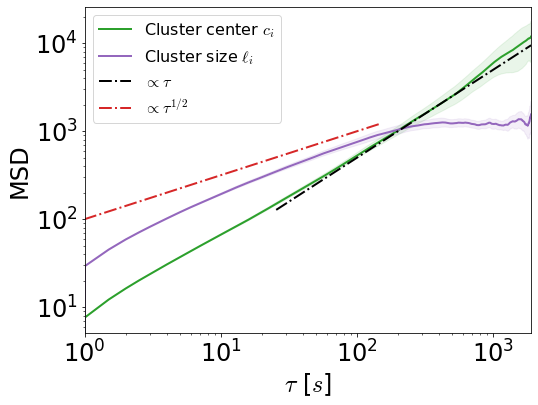

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ko = 15
# twin_ax = axarr.twinx()
with h5py.File("Figure7/fig7_single_cluster_data.h5", 'r') as h5_graph:
    msd_length = h5_graph['com_msd'][...].shape[1]
    
    com_msd_list = h5_graph['com_msd'][...]
    len_msd_list = h5_graph['len_msd'][...]

    # avg_time_arr = time_arr[1:max_length+1]
    avg_time_arr = h5_graph['time'][1:msd_length+1]

    # com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
    std_com_msd = np.std(com_msd_list, axis=0)
    avg_com_msd = np.mean(com_msd_list, axis=0)

    # len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
    std_len_msd = np.std(len_msd_list, axis=0)
    avg_len_msd = np.mean(len_msd_list, axis=0)

    plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color='C2', ci=.95, label='Cluster center $c_i$')
    plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
    # _ = axarr.loglog(time_arr[1:max_length+1], time_arr[1:max_length+1]*ko, c='k', linestyle='--')
    # _ = axarr.plot(time_arr[1:max_length+1], .25*15*time_arr[1:max_length+1], c='k', linestyle='--')
    # _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

    _ = axarr.set_ylabel(r"MSD")
    # _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
    _ = axarr.set_xlabel(r'$\tau$ [$s$]')
    _ = axarr.set_xlim(1,avg_time_arr[-1])

_ = axarr.loglog(avg_time_arr[50:], avg_time_arr[50:]*ko/3, c='k', linestyle='-.', label=r'$\propto \tau$')
_ = axarr.loglog(avg_time_arr[:300], 100*np.power(avg_time_arr[:300], .5), c='tab:red', linestyle='-.', label=r'$\propto \tau^{1/2}$')

_ = axarr.legend(fontsize=16)
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')


fig.savefig("Figure4/supp_cluster_msd_9um.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig4_supp_cluster_msd_9um.png", dpi=300, bbox_inches="tight")





(48, 2301)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


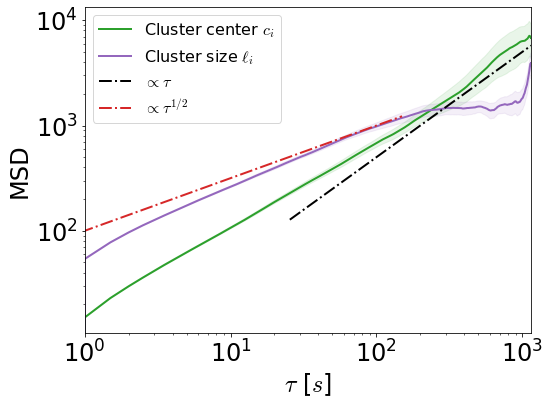

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ko = 15
# twin_ax = axarr.twinx()
with h5py.File("Figure6/fig6_single_cluster_ko300_data.h5", 'r') as h5_graph:
    print(h5_graph['com_msd'][...].shape)
    msd_length = h5_graph['com_msd'][...].shape[1]
    
    com_msd_list = h5_graph['com_msd'][...]
    len_msd_list = h5_graph['len_msd'][...]

    # avg_time_arr = time_arr[1:max_length+1]
    avg_time_arr = h5_graph['time'][1:msd_length+1]

    # com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
    std_com_msd = np.std(com_msd_list, axis=0)
    avg_com_msd = np.mean(com_msd_list, axis=0)

    # len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
    std_len_msd = np.std(len_msd_list, axis=0)
    avg_len_msd = np.mean(len_msd_list, axis=0)

    plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color='C2', ci=.95, label='Cluster center $c_i$')
    plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
    # _ = axarr.loglog(time_arr[1:max_length+1], time_arr[1:max_length+1]*ko, c='k', linestyle='--')
    # _ = axarr.plot(time_arr[1:max_length+1], .25*15*time_arr[1:max_length+1], c='k', linestyle='--')
    # _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

    _ = axarr.set_ylabel(r"MSD")
    # _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
    _ = axarr.set_xlabel(r'$\tau$ [$s$]')
    _ = axarr.set_xlim(1,avg_time_arr[-1])

_ = axarr.loglog(avg_time_arr[50:], avg_time_arr[50:]*ko/3, c='k', linestyle='-.', label=r'$\propto \tau$')
_ = axarr.loglog(avg_time_arr[:300], 100*np.power(avg_time_arr[:300], .5), c='tab:red', linestyle='-.', label=r'$\propto \tau^{1/2}$')

_ = axarr.legend(fontsize=16)
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')


fig.savefig("Figure4/supp_cluster_msd_ko300_9um.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_supp_cluster_ko300_msd_9um.png", dpi=300, bbox_inches="tight")

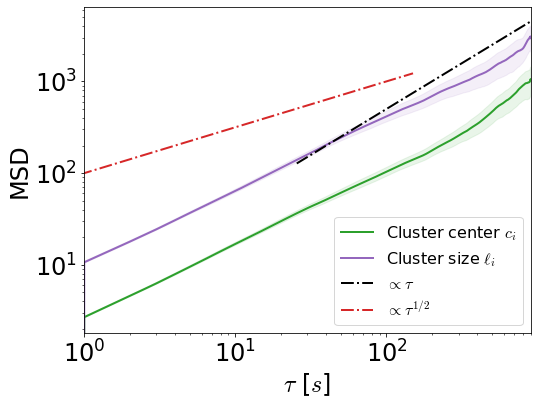

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ko = 15
# twin_ax = axarr.twinx()
with h5py.File("Figure6/fig6_single_cluster_ko3_data.h5", 'r') as h5_graph:
    len_msd_list = h5_graph['len_msd'][...]
    msd_length = h5_graph['com_msd'][...].shape[1]
    
    com_msd_list = h5_graph['com_msd'][...]
    len_msd_list = h5_graph['len_msd'][...]

    # avg_time_arr = time_arr[1:max_length+1]
    avg_time_arr = h5_graph['time'][1:msd_length+1]

    # com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
    std_com_msd = np.std(com_msd_list, axis=0)
    avg_com_msd = np.mean(com_msd_list, axis=0)

    # len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
    std_len_msd = np.std(len_msd_list, axis=0)
    avg_len_msd = np.mean(len_msd_list, axis=0)

    plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color='C2', ci=.95, label='Cluster center $c_i$')
    plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
    # _ = axarr.loglog(time_arr[1:max_length+1], time_arr[1:max_length+1]*ko, c='k', linestyle='--')
    # _ = axarr.plot(time_arr[1:max_length+1], .25*15*time_arr[1:max_length+1], c='k', linestyle='--')
    # _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

    _ = axarr.set_ylabel(r"MSD")
    # _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
    _ = axarr.set_xlabel(r'$\tau$ [$s$]')
    _ = axarr.set_xlim(1,avg_time_arr[-1])

_ = axarr.loglog(avg_time_arr[50:], avg_time_arr[50:]*ko/3, c='k', linestyle='-.', label=r'$\propto \tau$')
_ = axarr.loglog(avg_time_arr[:300], 100*np.power(avg_time_arr[:300], .5), c='tab:red', linestyle='-.', label=r'$\propto \tau^{1/2}$')

_ = axarr.legend(fontsize=16)
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')


fig.savefig("Figure4/supp_cluster_msd_ko3_9um.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig4_supp_cluster_msd_ko3_9um.png", dpi=300, bbox_inches="tight")

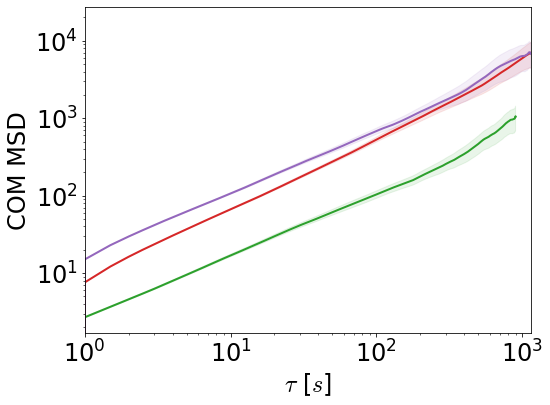

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ko = 15
# twin_ax = axarr.twinx()
for h5_path, color in zip(["Figure6/fig6_single_cluster_ko3_data.h5", "Figure6/fig6_single_cluster_data.h5", "Figure6/fig6_single_cluster_ko300_data.h5"], ('C2', 'C3', 'C4')):
    with h5py.File(h5_path, 'r') as h5_graph:
        len_msd_list = h5_graph['len_msd'][...]
        msd_length = h5_graph['com_msd'][...].shape[1]
        
        com_msd_list = h5_graph['com_msd'][...]
        len_msd_list = h5_graph['len_msd'][...]

        # avg_time_arr = time_arr[1:max_length+1]
        avg_time_arr = h5_graph['time'][1:msd_length+1]

        # com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
        std_com_msd = np.std(com_msd_list, axis=0)
        avg_com_msd = np.mean(com_msd_list, axis=0)

        # len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
        std_len_msd = np.std(len_msd_list, axis=0)
        avg_len_msd = np.mean(len_msd_list, axis=0)

        plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color=color, ci=.95, label='Cluster center $c_i$')
        # plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color='C4', ci=.95, label='Cluster size $\ell_i$')
        # _ = axarr.loglog(time_arr[1:max_length+1], time_arr[1:max_length+1]*ko, c='k', linestyle='--')
        # _ = axarr.plot(time_arr[1:max_length+1], .25*15*time_arr[1:max_length+1], c='k', linestyle='--')
        # _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

_ = axarr.set_ylabel(r"COM MSD")
# _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
_ = axarr.set_xlabel(r'$\tau$ [$s$]')

_ = axarr.set_xlim(1,avg_time_arr[-1])

# _ = axarr.loglog(avg_time_arr[50:], avg_time_arr[50:]*ko/3, c='k', linestyle='-.', label=r'$\propto \tau$')
# _ = axarr.loglog(avg_time_arr[:300], 100*np.power(avg_time_arr[:300], .5), c='tab:red', linestyle='-.', label=r'$\propto \tau^{1/2}$')

# _ = axarr.legend(fontsize=16)
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')


# fig.savefig("Figure6/supp_cluster_msd_ko3_9um.png", dpi=600,bbox_inches='tight')
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig5_supp_cluster_msd_ko3_9um.png", dpi=300, bbox_inches="tight")

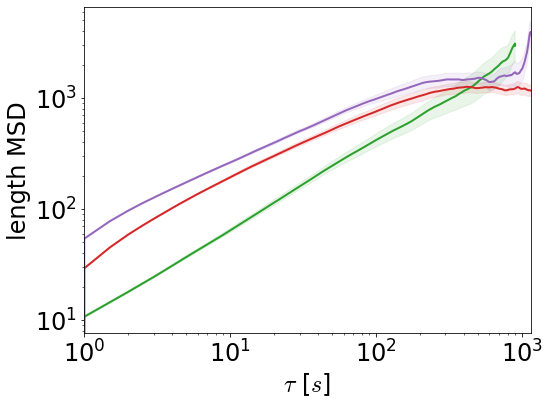

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ko = 15
# twin_ax = axarr.twinx()
for h5_path, color in zip(["Figure6/fig6_single_cluster_ko3_data.h5", "Figure6/fig6_single_cluster_data.h5", "Figure6/fig6_single_cluster_ko300_data.h5"], ('C2', 'C3', 'C4')):
    with h5py.File(h5_path, 'r') as h5_graph:
        len_msd_list = h5_graph['len_msd'][...]
        msd_length = h5_graph['com_msd'][...].shape[1]
        
        com_msd_list = h5_graph['com_msd'][...]
        len_msd_list = h5_graph['len_msd'][...]

        # avg_time_arr = time_arr[1:max_length+1]
        avg_time_arr = h5_graph['time'][1:msd_length+1]

        # com_msd_list = [com_msd[:max_length] for com_msd in com_msd_arr if len(com_msd) > max_length]
        std_com_msd = np.std(com_msd_list, axis=0)
        avg_com_msd = np.mean(com_msd_list, axis=0)

        # len_msd_list = [len_msd[:max_length] for len_msd in len_msd_arr if len(len_msd) > max_length]
        std_len_msd = np.std(len_msd_list, axis=0)
        avg_len_msd = np.mean(len_msd_list, axis=0)

        # plot_confidence_int(axarr, avg_time_arr, avg_com_msd, std_com_msd, num_runs=len(com_msd_list), color=color, ci=.95, label='Cluster center $c_i$')
        plot_confidence_int(axarr, avg_time_arr, avg_len_msd, std_len_msd, num_runs=len(len_msd_list), color=color, ci=.95, label='Cluster size $\ell_i$')
        # _ = axarr.loglog(time_arr[1:max_length+1], time_arr[1:max_length+1]*ko, c='k', linestyle='--')
        # _ = axarr.plot(time_arr[1:max_length+1], .25*15*time_arr[1:max_length+1], c='k', linestyle='--')
        # _ = twin_ax.loglog(time_arr[1:max_length+1], 30*time_arr[1:max_length+1], c='k', linestyle='--')

_ = axarr.set_ylabel(r"length MSD")
# _ = twin_ax.set_ylabel(r"Condensate size MSD [$\mu {\rm m}^2/s$]")
_ = axarr.set_xlabel(r'$\tau$ [$s$]')

_ = axarr.set_xlim(1,avg_time_arr[-1])

# _ = axarr.loglog(avg_time_arr[50:], avg_time_arr[50:]*ko/3, c='k', linestyle='-.', label=r'$\propto \tau$')
# _ = axarr.loglog(avg_time_arr[:300], 100*np.power(avg_time_arr[:300], .5), c='tab:red', linestyle='-.', label=r'$\propto \tau^{1/2}$')

# _ = axarr.legend(fontsize=16)
_ = axarr.set_xscale('log')
_ = axarr.set_yscale('log')


# fig.savefig("Figure6/supp_cluster_msd_ko3_9um.png", dpi=600,bbox_inches='tight')
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig5_supp_cluster_msd_ko3_9um.png", dpi=300, bbox_inches="tight")

# Collect data

In [4]:
slice_path = ceph_path / "DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations"

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40

pin_ko_data_dict = {}

def parse_params(param_dir):
    data_path = next(param_dir.glob("s*")) / "analysis/raw_data.h5"
    with h5py.File(data_path, "r") as h5_data:
        run_params = yaml.safe_load(h5_data.attrs["RunConfig"])
        prot_params = yaml.safe_load(h5_data.attrs["ProteinConfig"])

    return run_params["pinDist"], prot_params["proteins"][0]["ko_d"][1]


for param_dir in slice_path.glob("*"):
    print(param_dir)
    try:
        pin_dist, ko = parse_params(param_dir)
        if pin_dist not in pin_ko_data_dict:
            pin_ko_data_dict[pin_dist] = {}


        sd_h5_file_lst = [h5p for h5p in param_dir.glob("s*/analysis/raw_data.h5")]

        # For hdf5 file to help with graphing
        with h5py.File(sd_h5_file_lst[0], "r") as h5d:
            time_arr = h5d["time"][ss_ind:end_ind]
            nbeads = h5d["raw_data"]["sylinders"][start_bead:end_bead, 0, 0].shape[0]

        num_runs = len(sd_h5_file_lst)
        min_run_length = min(
            [len(h5py.File(h5p, "r")["time"]) for h5p in sd_h5_file_lst]
        )

        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_max_num_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))

        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / "cluster_analysis.h5"
            with h5py.File(h5_clust_file, "r") as h5_data:
                cluster_grp = h5_data["clusters"]
                time_grp_list = sorted(
                    cluster_grp.values(), key=lambda x: x.attrs["time"]
                )
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data=c) for c in tg.values()]]


            for c, clust_grp in enumerate(clusters):
                if c >= min_run_length:
                    break
                # Secondary thresholding
                clust_grp = [
                    clust for clust in clust_grp if len(clust.part_ids) > part_min
                ]

                num_beads = 0
                max_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)
                    max_beads = max(max_beads, len(clust.part_ids))

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads
                avg_max_num_beads_arr[ih, c] = max_beads

        num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
        num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
        num_clust_mean = avg_num_clust_arr.mean(axis=0)
        num_clust_std_dev = avg_num_clust_arr.std(axis=0)
        max_num_bead_mean = avg_max_num_beads_arr.mean(axis=0)
        max_num_bead_std_dev = avg_max_num_beads_arr.std(axis=0)
        pin_ko_data_dict[pin_dist][ko] = [
            num_bead_mean,
            num_bead_std_dev,
            num_clust_mean,
            num_clust_std_dev,
            max_num_bead_mean,
            max_num_bead_std_dev,
            num_runs,
        ]

    except:
        raise
        print("Error occured")

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod30_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod0.1_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod100_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod0.3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulations/kod0.3_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-26_aLc1_slice4.8.12_line1600_Pin3-9um_kod.1-300_2xKe30_ks100/simulatio

Note: This takes about 45 minutes to collect all the data.

In [5]:
# Store pin_ke_data_dict as an hdf5 file
with h5py.File('Figure4/fig4_pin_ko_data_dict.h5', 'w') as h5d:
    _ = h5d.create_dataset('time', data=time_arr)
    for pin_dist, ko_data in pin_ko_data_dict.items():
        for ko, data in ko_data.items():
            dset = h5d.create_dataset(f'kod{ko:.3g}_Pin{pin_dist:.1f}um', data=np.vstack(data[:-1]).T)
            dset.attrs['pin_dist'] = pin_dist
            dset.attrs['ko'] = ko
            dset.attrs['num_runs'] = data[-1]

In [ ]:
# np.array(com_msd_arr).shape
# max_length = 2400-start_index 
msd_length = min([len(arr) for arr in com_msd_arr])
print(msd_length)
com_msd_list =[com_msd[:msd_length] for com_msd in com_msd_arr if len(com_msd) >= msd_length]
len_msd_list = [len_msd[:msd_length] for len_msd in len_msd_arr if len(len_msd) >= msd_length]
com_list =[com[:msd_length] for com in com_arr_list if len(com) >= msd_length]
len_list = [leng[:msd_length] for leng in len_arr_list if len(leng) >= msd_length]

with h5py.File("Figure4/fig4_single_cluster_data.h5", 'w') as h5_graph:
    h5_graph.attrs['data_dir'] = '24-05-02_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_1patch'
    h5_graph.attrs['start_ind'] = start_index
    time_dset = h5_graph.create_dataset('time', data=np.array(time_arr))
    com_msd_dset = h5_graph.create_dataset('com_msd', data=np.array(com_msd_list))
    len_msd_dset = h5_graph.create_dataset('len_msd', data=np.array(len_msd_list))
    com_arr_dset = h5_graph.create_dataset('com', data=np.array(com_list))
    len_arr_dset = h5_graph.create_dataset('len', data=np.array(len_list))




3801


Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees


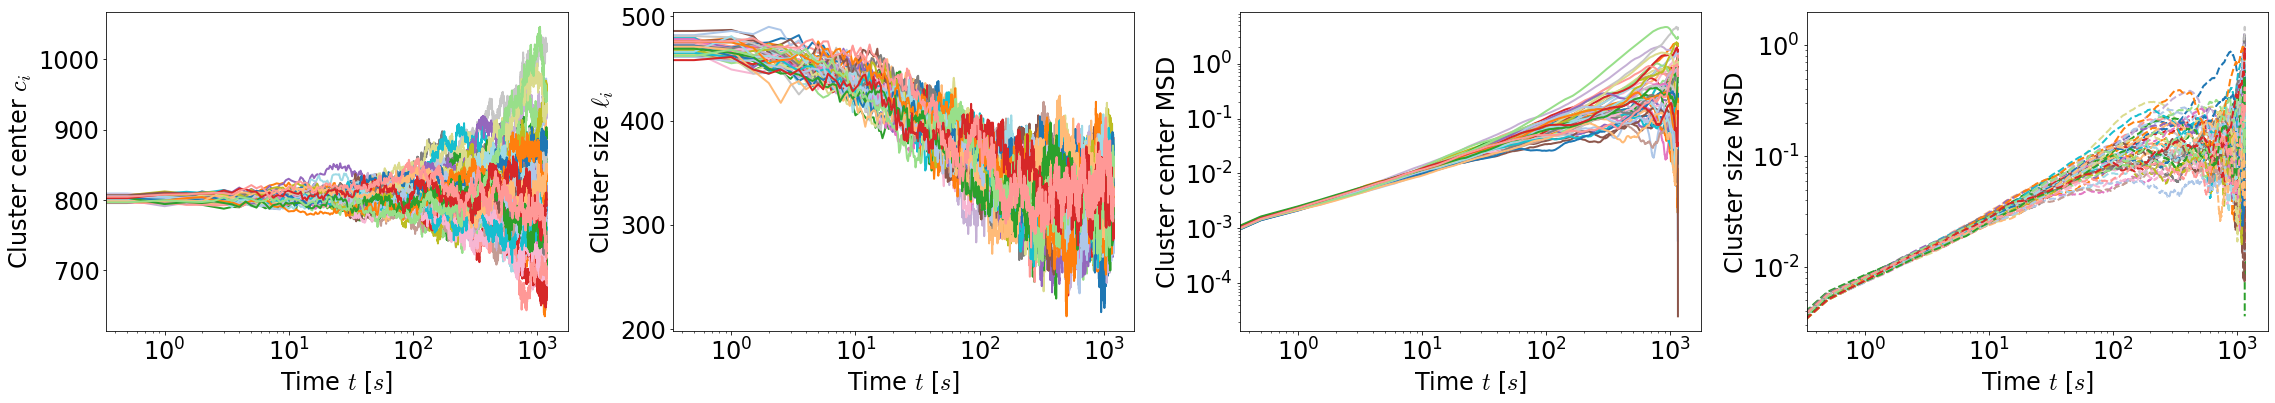

In [ ]:
data_path = ceph_path / "DynCondPaper/24-09-20_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_ko300_1patch"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))
large_tree_length = 100

tableau20_colors = iter(cycle(plt.cm.tab20.colors))
fig, axarr = plt.subplots(1,4, figsize=(32, 6), sharex=True)


com_msd_arr = []
len_msd_arr = []
com_arr_list = []
len_arr_list = []
for h5_cluster_file in h5_list:
    with h5py.File(h5_cluster_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]
    
    # Prune small trees
    trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

    print(f"Found {len(trees)} trees")
    if len(trees) != 1:
        print("Found multiple trees")
        continue


    # Graph all clusters
    for tree, color in zip(trees, tableau20_colors):
        clust_len_arr = []
        clust_com_arr = []
        time_arr = []
        # if len(tree.clusters) < large_tree_length:
        #     continue
        for clust in tree.clusters:
            clust_len_arr += [len(clust.part_ids)]
            clust_com_arr += [np.mean(clust.part_ids)]
            time_arr += [clust.time]
        
        # Sort arrays by time
        sort_indices = np.argsort(time_arr)
        clust_len_arr = np.array(clust_len_arr, dtype=float)[sort_indices]
        clust_com_arr = np.array(clust_com_arr)[sort_indices]
        time_arr = np.array(time_arr)[sort_indices]

        # Combine clusters with the same time
        unique_time, indices = np.unique(time_arr, return_inverse=True)

        # Initialize new arrays
        new_clust_len_arr = np.zeros(len(unique_time))
        new_clust_com_arr = np.zeros(len(unique_time))

        # Iterate over unique values
        for i, new_ind in enumerate(indices):
            new_clust_len_arr[new_ind] += clust_len_arr[i]
            new_clust_com_arr[new_ind] += clust_com_arr[i]*clust_len_arr[i]
        new_clust_com_arr /= new_clust_len_arr

        _ = axarr[0].plot(unique_time, new_clust_com_arr, c=color)
        _ = axarr[1].plot(unique_time, new_clust_len_arr, c=color)

        time_arr = unique_time
        clust_len_arr = new_clust_len_arr
        clust_com_arr = new_clust_com_arr

        start_index = 400

        com_msd = cluster_msd(clust_com_arr[start_index:], device=device)
        _ = axarr[2].plot(time_arr[:-start_index], com_msd*.01*.01, c=color)

        com_msd_arr.append(com_msd)
        com_arr_list.append(clust_com_arr)

        len_msd = cluster_msd(clust_len_arr[start_index:], device=device)
        _ = axarr[3].plot(time_arr[:-start_index], len_msd*.01*.01, c=color, linestyle='--')


        len_msd_arr.append(len_msd)
        len_arr_list.append(clust_len_arr)
    
_ = axarr[0].set_ylabel('Cluster center $c_i$')
_ = axarr[1].set_ylabel('Cluster size $\ell_i$')
_ = axarr[2].set_ylabel('Cluster center MSD')
_ = axarr[3].set_ylabel('Cluster size MSD')
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ [$s$]')
_ = axarr[2].set_xscale('log')
_ = axarr[2].set_yscale('log')
_ = axarr[3].set_yscale('log')

fig.tight_layout()


In [ ]:
# np.array(com_msd_arr).shape
# max_length = 2400-start_index 
msd_length = min([len(arr) for arr in com_msd_arr])
print(msd_length)
com_msd_list =[com_msd[:msd_length] for com_msd in com_msd_arr if len(com_msd) >= msd_length]
len_msd_list = [len_msd[:msd_length] for len_msd in len_msd_arr if len(len_msd) >= msd_length]
com_list =[com[:msd_length] for com in com_arr_list if len(com) >= msd_length]
len_list = [leng[:msd_length] for leng in len_arr_list if len(leng) >= msd_length]

with h5py.File("Figure4/fig4_single_cluster_ko300_data.h5", 'w') as h5_graph:
    h5_graph.attrs['data_dir'] = '24-09-20_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_ko300_1patch'
    h5_graph.attrs['start_ind'] = start_index
    time_dset = h5_graph.create_dataset('time', data=np.array(time_arr))
    com_msd_dset = h5_graph.create_dataset('com_msd', data=np.array(com_msd_list))
    len_msd_dset = h5_graph.create_dataset('len_msd', data=np.array(len_msd_list))
    com_arr_dset = h5_graph.create_dataset('com', data=np.array(com_list))
    len_arr_dset = h5_graph.create_dataset('len', data=np.array(len_list))




2301


Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees
Found 1 trees


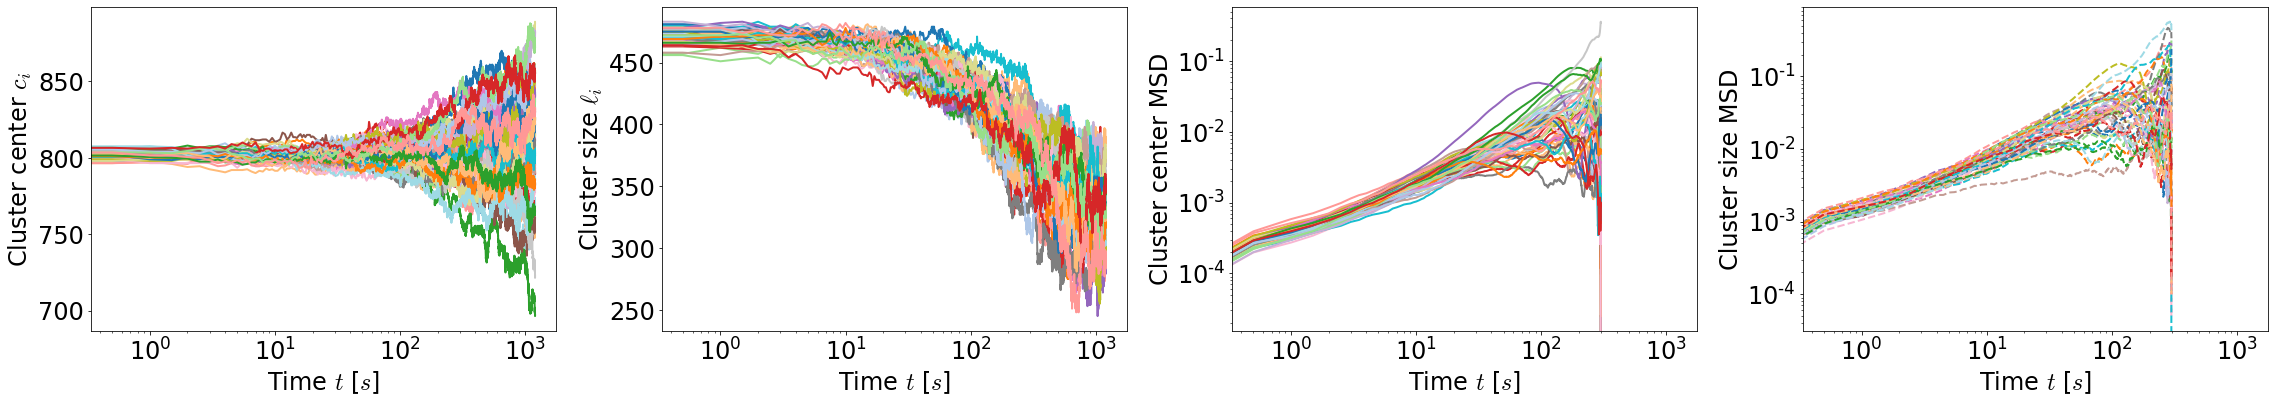

In [ ]:
data_path = ceph_path / "DynCondPaper/24-09-20_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_ko3_1patch"
h5_list = list(data_path.glob('simulations/*/analysis/cluster_analysis.h5'))
large_tree_length = 100

tableau20_colors = iter(cycle(plt.cm.tab20.colors))
fig, axarr = plt.subplots(1,4, figsize=(32, 6), sharex=True)


com_msd_arr = []
len_msd_arr = []
com_arr_list = []
len_arr_list = []
for h5_cluster_file in h5_list:
    with h5py.File(h5_cluster_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_arr = h5_data['time'][...]
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        clusters = []
        for tg in time_grp_list:
            clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

    # Cluster tree
    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]
    
    # Prune small trees
    trees = [tree for tree in trees if len(tree.clusters) > large_tree_length]

    print(f"Found {len(trees)} trees")
    if len(trees) != 1:
        print("Found multiple trees")
        continue


    # Graph all clusters
    for tree, color in zip(trees, tableau20_colors):
        clust_len_arr = []
        clust_com_arr = []
        time_arr = []
        # if len(tree.clusters) < large_tree_length:
        #     continue
        for clust in tree.clusters:
            clust_len_arr += [len(clust.part_ids)]
            clust_com_arr += [np.mean(clust.part_ids)]
            time_arr += [clust.time]
        
        # Sort arrays by time
        sort_indices = np.argsort(time_arr)
        clust_len_arr = np.array(clust_len_arr, dtype=float)[sort_indices]
        clust_com_arr = np.array(clust_com_arr)[sort_indices]
        time_arr = np.array(time_arr)[sort_indices]

        # Combine clusters with the same time
        unique_time, indices = np.unique(time_arr, return_inverse=True)

        # Initialize new arrays
        new_clust_len_arr = np.zeros(len(unique_time))
        new_clust_com_arr = np.zeros(len(unique_time))

        # Iterate over unique values
        for i, new_ind in enumerate(indices):
            new_clust_len_arr[new_ind] += clust_len_arr[i]
            new_clust_com_arr[new_ind] += clust_com_arr[i]*clust_len_arr[i]
        new_clust_com_arr /= new_clust_len_arr

        _ = axarr[0].plot(unique_time, new_clust_com_arr, c=color)
        _ = axarr[1].plot(unique_time, new_clust_len_arr, c=color)

        time_arr = unique_time
        clust_len_arr = new_clust_len_arr
        clust_com_arr = new_clust_com_arr
        
        start_index = -600


        com_msd = cluster_msd(clust_com_arr[start_index:], device=device)
        _ = axarr[2].plot(time_arr[:-start_index], com_msd*.01*.01, c=color)

        com_msd_arr.append(com_msd)
        com_arr_list.append(clust_com_arr)

        len_msd = cluster_msd(clust_len_arr[start_index:], device=device)
        _ = axarr[3].plot(time_arr[:-start_index], len_msd*.01*.01, c=color, linestyle='--')


        len_msd_arr.append(len_msd)
        len_arr_list.append(clust_len_arr)
    
_ = axarr[0].set_ylabel('Cluster center $c_i$')
_ = axarr[1].set_ylabel('Cluster size $\ell_i$')
_ = axarr[2].set_ylabel('Cluster center MSD')
_ = axarr[3].set_ylabel('Cluster size MSD')
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ [$s$]')
_ = axarr[2].set_xscale('log')
_ = axarr[2].set_yscale('log')
_ = axarr[3].set_yscale('log')

fig.tight_layout()

In [ ]:
# np.array(com_msd_arr).shape
# max_length = 2400-start_index 
msd_length = min([len(arr) for arr in com_msd_arr])
print(msd_length)
com_msd_list =[com_msd[:msd_length] for com_msd in com_msd_arr if len(com_msd) >= msd_length]
len_msd_list = [len_msd[:msd_length] for len_msd in len_msd_arr if len(len_msd) >= msd_length]
com_list =[com[:msd_length] for com in com_arr_list if len(com) >= msd_length]
len_list = [leng[:msd_length] for leng in len_arr_list if len(leng) >= msd_length]

with h5py.File("Figure4/fig4_single_cluster_ko3_data.h5", 'w') as h5_graph:
    h5_graph.attrs['data_dir'] = '24-09-20_aLc1_scan.48_line1600_Pin9um_2xKe30_ks100_ko3_1patch'
    h5_graph.attrs['start_ind'] = start_index
    time_dset = h5_graph.create_dataset('time', data=np.array(time_arr))
    com_msd_dset = h5_graph.create_dataset('com_msd', data=np.array(com_msd_list))
    len_msd_dset = h5_graph.create_dataset('len_msd', data=np.array(len_msd_list))
    com_arr_dset = h5_graph.create_dataset('com', data=np.array(com_list))
    len_arr_dset = h5_graph.create_dataset('len', data=np.array(len_list))




1801
